# 1.MindSpore深度学习框架下实现

### 设置MindSpore运行于图模式，硬件平台为CPU

In [1]:
from mindspore import context
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

### 生成训练样本并增强

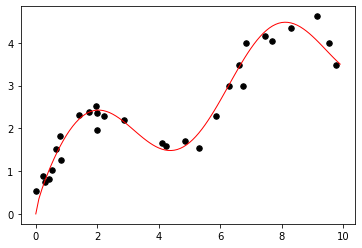

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1101) # 指定随机数种子，产生相同的随机数，便于观察试验结果

def f(x): # 目标函数
    return x**0.6 + np.sin(x)

def get_data(num, start, end): # 产生训练样本
    for _ in range(num):
        x = np.random.uniform(start, end)
        noise = np.random.normal(0, 0.3)
        y = f(x) + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

start = 0.0 # 生成样本的区间起点
end = 10.0 # 生成样本的区间终点
data_number = 30 # 生成样本总数
batch_size = 5 # 每批训练样本数（批梯度下降法）
repeat_size = 1 # 样本重复次数

train_data = list(get_data(data_number, start, end))
X, y = zip(*train_data)

plt.scatter(X, y, color="black", s=30)
xx = np.arange(start, end, 0.1) # 验证样本
yy = f(xx) # 验证样本的标签
plt.plot(xx, yy, color="red", linewidth=1, linestyle='-')
plt.show()

In [3]:
# 归一化训练样本标签值
miny = np.inf
maxy = -1 * np.inf
for i in range(len(train_data)): # tuple to list
    train_data[i] = list(train_data[i])
for data in train_data:
    if data[1] > maxy:
        maxy = data[1]
    if data[1] < miny:
        miny = data[1]
step = maxy - miny
for data in train_data:
    data[1] = ( data[1] - miny ) / step

In [4]:
from mindspore import dataset as ds

ds_train = ds.GeneratorDataset(train_data, column_names=['samples', 'label'])
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.repeat(repeat_size)
    
print("The dataset size of ds_train:", ds_train.get_dataset_size())
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["samples"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

The dataset size of ds_train: 6
dict_keys(['samples', 'label'])
The x label value shape: (5, 1)
The y label value shape: (5, 1)


### 构建多层神经网络

In [5]:
from mindspore.common.initializer import Normal
from mindspore import nn, Parameter

class NonLinearNet(nn.Cell):
    def __init__(self):
        super(NonLinearNet, self).__init__()
        self.fc1 = nn.Dense(1, 5, Normal(0.02), Normal(0.02), True)
        self.fc2 = nn.Dense(5, 5, Normal(0.02), Normal(0.02), True)
        self.fc3 = nn.Dense(5, 1, Normal(0.02), Normal(0.02), True)
        self.sigmoid = nn.Sigmoid()
        
    def construct(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

net = NonLinearNet() # 实例化

# 查看模型参数初始值
#model_params = net.trainable_params()
#for param in model_params:
#    print(param, param.asnumpy())

In [6]:
from mindspore import Model
from mindspore.nn import MSE

net_loss = nn.loss.MSELoss() # 定义损失函数
opt = nn.Momentum(net.trainable_params(), learning_rate=0.1, momentum=0.9) # 定义优化方法
ms_model = Model(net, net_loss, opt) # 将网络结构、损失函数和优化方法进行关联

### 训练模型

In [7]:
ms_epoch = 6000
ms_model.train(ms_epoch, ds_train, dataset_sink_mode=False)

#for param in net.trainable_params():
#    print(param, param.asnumpy())

In [8]:
import mindspore
from mindspore import Tensor
eval_data = Tensor(xx.reshape(-1,1), mindspore.float32)

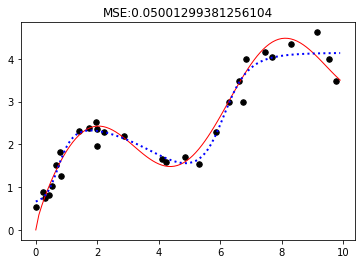

In [9]:
pred = ms_model.predict(eval_data).asnumpy()

for i in range(len(pred)): # 对验证样本的预测标签值进行反归一化
    pred[i] = miny + pred[i] * step

xxx = Tensor(yy, mindspore.float32)
yyy = Tensor(pred.reshape(-1), mindspore.float32)
error = nn.MSE()
error.clear()
error.update(xxx, yyy)
result = error.eval()

plt.scatter(X, y, color="black", s=30)
plt.plot(xx, yy, color="red", linewidth=1, linestyle='-')
plt.plot(xx, pred, color="blue", linewidth=2, linestyle=':')
plt.title(u'MSE:'+str(result))
plt.show()

### ！！！新版本变化：MindSpore1.7.0已经在CPU平台上支持SGD算子，下面给出用SGD优化的示例

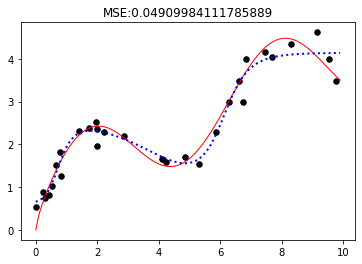

In [20]:
opt_sgd = nn.SGD(net.trainable_params()) # 定义优化方法
ms_model = Model(net, net_loss, opt_sgd) # 将网络结构、损失函数和优化方法进行关联

ds_train1 = ds.GeneratorDataset(train_data, column_names=['samples', 'label'])
ds_train1 = ds_train1.batch(batch_size)
ds_train1 = ds_train1.repeat(repeat_size)

ms_model.train(ms_epoch, ds_train1, dataset_sink_mode=False)
pred = ms_model.predict(eval_data).asnumpy()
for i in range(len(pred)): # 对验证样本的预测标签值进行反归一化
    pred[i] = miny + pred[i] * step

xxx = Tensor(yy, mindspore.float32)
yyy = Tensor(pred.reshape(-1), mindspore.float32)
error = nn.MSE()
error.clear()
error.update(xxx, yyy)
result = error.eval()

plt.scatter(X, y, color="black", s=30)
plt.plot(xx, yy, color="red", linewidth=1, linestyle='-')
plt.plot(xx, pred, color="blue", linewidth=2, linestyle=':')
plt.title(u'MSE:'+str(result))
plt.show()

# 2.TensorFlow2.0深度学习框架下实现

### 构建多层神经网络

！！！新版本变化：TensorFlow2.0.0版本下的代码不能正常运行，报错ModuleNotFoundError: No module named 'keras'

In [10]:
import tensorflow.keras as keras
tf_model = keras.Sequential([
    keras.layers.Dense(5, activation='sigmoid', input_shape=(1,), kernel_initializer='random_uniform', bias_initializer='zeros'),
    keras.layers.Dense(5, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='zeros'),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='zeros')
])

In [11]:
y1 = np.array(y)
for i in range(len(y)): # 归一化训练样本标签值
    y1[i] = ( y1[i] - miny ) / step

In [12]:
y1 = y1.reshape(-1)
X = np.array(X)
X = X.reshape(-1)

In [13]:
tf_epoch = 6000
tf_model.compile(optimizer='sgd', loss='mean_squared_error')
tf_model.fit(X, y1, batch_size=batch_size, epochs=tf_epoch, verbose=1)
tf_model.summary()

Epoch 1/6000
6/6 [==============================] - 1s 16ms/step - loss: 0.0831
Epoch 2/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0831
Epoch 3/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0830
Epoch 4/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0829
Epoch 5/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0828
Epoch 6/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0828
Epoch 7/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0828
Epoch 8/6000
6/6 [==============================] - 0s 9ms/step - loss: 0.0827
Epoch 9/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0827
Epoch 10/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0826
Epoch 11/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0826
Epoch 12/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0825
Epoch 13/6000
6/6 [=============================

6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 205/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 206/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 207/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 208/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 209/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 210/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 211/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 212/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 213/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 214/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 215/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 216/6000
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 407/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 408/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 409/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 410/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 411/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 412/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 413/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 414/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 415/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 416/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 417/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 418/6000
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 609/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 610/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 611/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 612/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 613/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 614/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 615/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 616/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 617/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 618/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 619/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 620/6000
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 811/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 812/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 813/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 814/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 815/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 816/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 817/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 818/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 819/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 820/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 821/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 822/6000
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1013/6000
6/6 [==============================] - 0s 18ms/step - loss: 0.0813
Epoch 1014/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 1015/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 1016/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1017/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1018/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1019/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1020/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1021/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1022/6000
6/6 [==============================] - 0s 59ms/step - loss: 0.0813
Epoch 1023/6000
6/6 [==============================] - 0s 13ms/step - loss: 0.0813
Epoch 1024/6000
6/6 [========

6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 1211/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 1212/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1213/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1214/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1215/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1216/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1217/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1218/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1219/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1220/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1221/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1222/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1311/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1312/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1313/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1314/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1315/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1316/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1317/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1318/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 1319/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 1320/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1321/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1322/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1411/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1412/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1413/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1414/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1415/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 1416/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1417/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1418/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 1419/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1420/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1421/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1422/6000
6/6 [===========

6/6 [==============================] - 0s 8ms/step - loss: 0.0813
Epoch 1511/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1512/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1513/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1514/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1515/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1516/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1517/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1518/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1519/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 1520/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1521/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1522/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1611/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1612/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1613/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1614/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1615/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1616/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1617/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1618/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1619/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1620/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1621/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1622/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1711/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1712/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1713/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1714/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1715/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1716/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1717/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 1718/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 1719/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1720/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1721/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1722/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1811/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1812/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 1813/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1814/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1815/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1816/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 1817/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1818/6000
6/6 [==============================] - 0s 9ms/step - loss: 0.0813
Epoch 1819/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 1820/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1821/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1822/6000
6/6 [===========

6/6 [==============================] - 0s 8ms/step - loss: 0.0812
Epoch 1911/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1912/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1913/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1914/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1915/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1916/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1917/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1918/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1919/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1920/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 1921/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 1922/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2011/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2012/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2013/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 2014/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2015/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2016/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2017/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2018/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2019/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 2020/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2021/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2022/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2111/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 2112/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2113/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2114/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2115/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2116/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 2117/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 2118/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2119/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2120/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2121/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2122/6000
6/6 [===========

Epoch 2210/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 2211/6000
6/6 [==============================] - 0s 14ms/step - loss: 0.0813
Epoch 2212/6000
6/6 [==============================] - 0s 10ms/step - loss: 0.0813
Epoch 2213/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0813
Epoch 2214/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2215/6000
6/6 [==============================] - 0s 12ms/step - loss: 0.0813
Epoch 2216/6000
6/6 [==============================] - 0s 9ms/step - loss: 0.0813
Epoch 2217/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2218/6000
6/6 [==============================] - 0s 13ms/step - loss: 0.0813
Epoch 2219/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2220/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2221/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2222/6

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2410/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2411/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2412/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2413/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2414/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2415/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2416/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2417/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2418/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2419/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2420/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2421/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2510/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 2511/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2512/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2513/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 2514/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2515/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2516/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 2517/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2518/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2519/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2520/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2521/6000
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2610/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0813
Epoch 2611/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2612/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2613/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2614/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 2615/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2616/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2617/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2618/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2619/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2620/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2621/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2710/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 2711/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 2712/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 2713/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2714/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2715/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 2716/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 2717/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2718/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2719/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2720/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2721/6000
6/6 [===========

6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 2810/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 2811/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 2812/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 2813/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2814/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 2815/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 2816/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2817/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2818/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 2819/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2820/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 2821/6000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2910/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 2911/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2912/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 2913/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2914/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2915/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2916/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2917/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 2918/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 2919/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2920/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 2921/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3010/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 3011/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 3012/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 3013/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 3014/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3015/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3016/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3017/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 3018/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0813
Epoch 3019/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3020/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3021/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 3110/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3111/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 3112/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3113/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3114/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3115/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3116/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3117/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 3118/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3119/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3120/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3121/6000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3210/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3211/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 3212/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 3213/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 3214/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3215/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 3216/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 3217/6000
6/6 [==============================] - 0s 13ms/step - loss: 0.0813
Epoch 3218/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3219/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3220/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 3221/6000
6/6 [==========

6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 3310/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 3311/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 3312/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 3313/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 3314/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3315/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3316/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3317/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3318/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3319/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3320/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3321/6000
6/6 [===========

Epoch 3409/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3410/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 3411/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 3412/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3413/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3414/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3415/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 3416/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 3417/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 3418/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0813
Epoch 3419/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3420/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3421/6000


Epoch 3608/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3609/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3610/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3611/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3612/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3613/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3614/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3615/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 3616/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3617/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3618/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3619/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3620/6000


6/6 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 3808/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 3809/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 3810/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3811/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 3812/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3813/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3814/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 3815/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 3816/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 3817/6000
6/6 [==============================] - 0s 29ms/step - loss: 0.0812
Epoch 3818/6000
6/6 [==============================] - 0s 9ms/step - loss: 0.0812
Epoch 3819/6000
6/6 [==========

6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4007/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4008/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 4009/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4010/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4011/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 4012/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 4013/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4014/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4015/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4016/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4017/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4018/6000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4107/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4108/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4109/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 4110/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4111/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4112/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4113/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4114/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4115/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4116/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4117/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4118/6000
6/6 [===========

6/6 [==============================] - 0s 8ms/step - loss: 0.0812
Epoch 4207/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4208/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 4209/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4210/6000
6/6 [==============================] - 0s 21ms/step - loss: 0.0812
Epoch 4211/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4212/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4213/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4214/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4215/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 4216/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4217/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4218/6000
6/6 [==========

Epoch 4306/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4307/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4308/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 4309/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4310/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4311/6000
6/6 [==============================] - ETA: 0s - loss: 0.095 - 0s 6ms/step - loss: 0.0812
Epoch 4312/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4313/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4314/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4315/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4316/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4317/6000
6/6 [==============================] - 0s 3ms/step - loss:

6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4506/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4507/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4508/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4509/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4510/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4511/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4512/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4513/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4514/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 4515/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 4516/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4517/6000
6/6 [===========

6/6 [==============================] - 0s 8ms/step - loss: 0.0812
Epoch 4606/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4607/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4608/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4609/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4610/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 4611/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4612/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4613/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0812
Epoch 4614/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4615/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0813
Epoch 4616/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4617/6000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4706/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4707/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4708/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4709/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 4710/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4711/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4712/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4713/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4714/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4715/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 4716/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4717/6000
6/6 [===========

Epoch 4805/6000
6/6 [==============================] - 0s 21ms/step - loss: 0.0812
Epoch 4806/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4807/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 4808/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 4809/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4810/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4811/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4812/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4813/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 4814/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4815/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 4816/6000
6/6 [==============================] - 0s 9ms/step - loss: 0.0812
Epoch 4817/6000

6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5005/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5006/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5007/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 5008/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5009/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5010/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0812
Epoch 5011/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5012/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0811
Epoch 5013/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 5014/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 5015/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 5016/6000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5105/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 5106/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 5107/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5108/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5109/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5110/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5111/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 5112/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 5113/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5114/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5115/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 5116/6000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5205/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5206/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 5207/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5208/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5209/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5210/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5211/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5212/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 5213/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5214/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5215/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5216/6000
6/6 [===========

6/6 [==============================] - 0s 16ms/step - loss: 0.0811
Epoch 5305/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5306/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5307/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5308/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5309/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5310/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5311/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5312/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5313/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5314/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 5315/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5316/6000
6/6 [==========

Epoch 5404/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5405/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0812
Epoch 5406/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5407/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5408/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5409/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 5410/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5411/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5412/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5413/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5414/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5415/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 5416/6000


6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5603/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5604/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 5605/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5606/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0811
Epoch 5607/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5608/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5609/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5610/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5611/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5612/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5613/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0811
Epoch 5614/6000
6/6 [===========

Epoch 5702/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 5703/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0812
Epoch 5704/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5705/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5706/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5707/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5708/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5709/6000
6/6 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 5710/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5711/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5712/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5713/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5714/6000


6/6 [==============================] - 0s 6ms/step - loss: 0.0811
Epoch 5902/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0811
Epoch 5903/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5904/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5905/6000
6/6 [==============================] - 0s 7ms/step - loss: 0.0811
Epoch 5906/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5907/6000
6/6 [==============================] - 0s 8ms/step - loss: 0.0810
Epoch 5908/6000
6/6 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 5909/6000
6/6 [==============================] - 0s 6ms/step - loss: 0.0810
Epoch 5910/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5911/6000
6/6 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 5912/6000
6/6 [==============================] - 0s 5ms/step - loss: 0.0811
Epoch 5913/6000
6/6 [===========

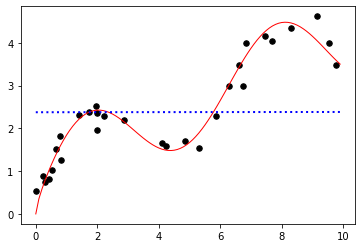

In [14]:
pred = tf_model.predict(xx)
for i in range(len(pred)): # 对验证样本的预测标签值进行反归一化
    pred[i] = miny + pred[i] * step
pred = pred.reshape(-1)

plt.scatter(X, y, color="black", s=30)
plt.plot(xx, yy, color="red", linewidth=1, linestyle='-')
plt.plot(xx, pred, color="blue", linewidth=2, linestyle=':')
plt.show()

In [15]:
X

array([8.310883  , 0.7807782 , 6.7474346 , 6.602213  , 0.64134496,
       0.02058768, 0.2292933 , 1.9442806 , 1.7175306 , 4.0963063 ,
       6.2732196 , 1.9784914 , 9.546741  , 6.8211765 , 9.161772  ,
       0.8272693 , 9.751238  , 2.878935  , 5.8724294 , 4.83789   ,
       0.4312307 , 1.9827317 , 0.5112423 , 4.236168  , 5.300756  ,
       7.6798086 , 7.4488893 , 0.30652153, 1.4129992 , 2.2312772 ],
      dtype=float32)